# ISMIR 2018 Tutorial
# Deep Learning for Music Information Retrieval

## Part 1: Convolutional Neural Networks for Instrumental, Genre and Mood Recognition

Author: Thomas Lidy

This tutorial shows how different Convolutional Neural Network architectures are used for:
* Instrumental vs. Vocal Detection:  detecting whether a piece of music is instrumental or contains vocals
* Genre Classification
* Mood Recognition

The data set used is a subset of the [MagnaTagATune Dataset](http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) with only 1 sample excerpt of each of the original audio files.

The annotations of the original dataset contain a multitude of tags, which were preprocessed in Part 0 of this tutorial in order to create 3 groundtruth files for instrumental/vocal, genre and mood recognition.

Likewise, the original audio files were preprocessed to extract Mel spectrograms as an input for this Part 1 of the tutorial; also refer to Part 0 on how this preprocessing was done.

### Requirements

* Python >= 3.5
* Keras >= 2.1.1
* Tensorflow
* scikit-learn >= 0.18
* Pandas
* Librosa
* MatplotLib

### Download Data

If you haven't already (following the [README](./README.md#download-prepared-datasets)), 
please download the following prepared data (from MagnaTagaTune data set) for this tutorial:

**Download prepared spectrograms:** https://owncloud.tuwien.ac.at/index.php/s/bxY87m3k4oMaoFl (96MB)

Unzip the file e.g. inside this Tutorial folder, and adapt the following `SPECTROGRAM_PATH` variable:

In [1]:
# SET PATH OF DOWNLOADED DATA HERE
# (can be relative path if you unzipped the files inside this tutorial's folder)

SPECTROGRAM_PATH = 'ISMIR2018_tut_melspecs_subset'

# included in repository
METADATA_PATH = 'metadata'

import os
from os.path import join

# here, %s will be replace by 'instrumental', 'genres' or 'moods'
LABEL_FILE_PATTERN = join(METADATA_PATH, 'ismir2018_tut_part_1_%s_labels_subset_w_clipid.csv') 
SPECTROGRAM_FILE_PATTERN = join(SPECTROGRAM_PATH, 'ISMIR2018_tut_melspecs_part_1_%s_subset.npz')

In [2]:
# IF YOU USE A GPU, you may set which GPU(s) to use here:
# (this has to be set before the import of Keras and Tensorflow)
os.environ["CUDA_VISIBLE_DEVICES"]="0" #"0,1,2,3" 

In [3]:
# General Imports

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd # Pandas for reading CSV files and easier Data handling in preparation

# Deep Learning

import keras
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# Machine Learning preprocessing and evaluation

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 1) Instrumental vs. Vocal Detection

This is a binary classification task to detect whether a piece of audio is instrumental or vocal (= singing or voice). The output decision is *either* 0 *or* 1.

## Load Audio Spectrograms

We have pre-processed the audio files already and extracted Mel spectrograms. We load these from a Numpy .npz file, which contains the spectrograms and also the associated clip ids.

In [4]:
task = 'instrumental'
SPECTROGRAM_FILE = SPECTROGRAM_FILE_PATTERN % task

with np.load(SPECTROGRAM_FILE) as npz:
    spectrograms = npz["features"]
    spec_clip_ids = npz["clip_id"]

# check how many spectrograms we have and their dimensions
spectrograms.shape

(1703, 80, 80)

In [5]:
# double-check whether we have the same number of ids from spectrogram file
len(spec_clip_ids)

1703

In [6]:
# create dataframe that associates the index order of the spectrograms with the clip_ids
spectrograms_clip_ids = pd.DataFrame({"spec_id": np.arange(spectrograms.shape[0])}, index = spec_clip_ids)
spectrograms_clip_ids.index.name = 'clip_id'
spectrograms_clip_ids.head()

,spec_id
clip_id,
37,0
40,1
172,2
198,3
253,4


In [7]:
# we define the same in a convenience function used later
def load_spectrograms(spectrogram_filename):
    # load spectrograms
    with np.load(spectrogram_filename) as npz:
        spectrograms = npz["features"]
        spec_clip_ids = npz["clip_id"]
    # create dataframe that associates the index order of the spectrograms with the clip_ids
    spectrograms_clip_ids = pd.DataFrame({"spec_id": np.arange(spectrograms.shape[0])}, index = spec_clip_ids)
    spectrograms_clip_ids.index.name = 'clip_id'
    return spectrograms, spectrograms_clip_ids

### Show Mel Spectrogram (1 example just for illustration)

In [8]:
# you can skip this if you do not have matplotlib installed

import matplotlib.pyplot as plt
%matplotlib inline 

In [9]:
# take first spectrogram as an example
i = 10
spec = spectrograms[i]

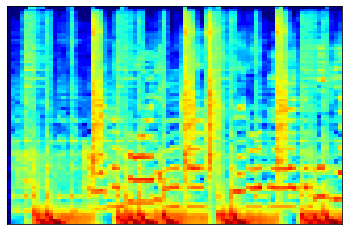

In [10]:
# plot it 
fig = plt.imshow(spec, origin='lower', aspect='auto')
fig.set_cmap('jet')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network! (unless you use BatchNormalization in your Neural Network)

We use <b>Zero-mean Unit-variance standardization</b> (also known as Z-score normalization).
Here, we use <b>attribute-wise standardization</b>, i.e. each pixel is standardized individually, as opposed to computing a single mean and single standard deviation of all values.

('Flat' standardization would also be possible, but we have seen benefits of attribute-wise standardization in our experiments).

We use the StandardScaler from the scikit-learn package for our purpose.
As it works typically on vector data, we have to vectorize (i.e. reshape) our matrices first, and then reshape again to the original shape. We created a convenience function for that:

In [11]:
def standardize(data):
    # vectorize before standardization (cause scaler can't do it in that format)
    N, ydim, xdim = data.shape
    data = data.reshape(N, xdim*ydim)

    # standardize
    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    # reshape to original shape
    return data.reshape(N, ydim, xdim)

In [12]:
spectrograms = standardize(spectrograms)
spectrograms.shape # verify that the shape is again the same as before

(1703, 80, 80)

## Load the Metadata

In [13]:
# use META_FILE_PATTERN to load the correct metadata file. set correct METADATA_PATH above
task = 'instrumental'
csv_file = LABEL_FILE_PATTERN % task

metadata = pd.read_csv(csv_file, index_col=0) #, sep='\t')
metadata.shape

(1680, 1)

In [14]:
metadata.head()

,instrumental
clip_id,
37,0.0
40,0.0
172,1.0
198,0.0
253,0.0


In [15]:
# how many instrumental tracks
metadata.sum()

instrumental    420.0
dtype: float64

In [16]:
# how many vocal tracks
(1-metadata).sum()

instrumental    1260.0
dtype: float64

In [17]:
# baseline:
1260/len(metadata)

0.75

## Align Metadata and Spectrograms

In [18]:
len(metadata)

1680

In [19]:
# check if we find all metadata clip ids in our spectrogram data
len(set(metadata.index).intersection(set(spec_clip_ids)))

1680

In [20]:
# we may have more spectrograms than metadata
spectrograms.shape

(1703, 80, 80)

### Create Train X and Y: data and classes

**get the correct spectrogram indices given the metadata's clip_ids in a sorted way**

In [21]:
meta_clip_ids = metadata.index
spec_indices = spectrograms_clip_ids.loc[meta_clip_ids]['spec_id']

**and select a correctly sorted subset of the original spectrograms for this task**

In [22]:
data = spectrograms[spec_indices,:]
data.shape

(1680, 80, 80)

In [23]:
# for training convert from Pandas DataFrame to numpy array
classes = metadata.values
classes

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [24]:
# number of classes is number of columns in metaddata
n_classes = metadata.shape[1]

# Convolutional Neural Networks

A Convolutional Neural Network (ConvNet or CNN) is a type of (Deep) Neural Network that is well-suited for 2D axes data, such as images or spectrograms, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and down-scaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), typically followed by a pooling step, which aggregates neighboring pixels together and thus reduces the image resolution by retaining only the average or maximum values of neighboring pixels.

## Preparing the Data

### Adding the channel

As CNNs were initially made for image data, we need to add a dimension for the color channel to the data. RGB images typically have a 3rd dimension with the color. 

<b>Spectrograms, however, are considered like greyscale images, as in the previous tutorial.
Likewise we need to add an extra dimension for compatibility with the CNN implementation.</b>

For greyscale images, we add the number 1 as the depth of the additional dimension of the input shape (for RGB color images, the number of channels is 3).

In [25]:
def add_channel(data, n_channels=1):
    # n_channels: 1 for grey-scale, 3 for RGB, but usually already present in the data
    
    N, ydim, xdim = data.shape

    if keras.backend.image_data_format() == 'channels_last':  # TENSORFLOW
        # Tensorflow ordering (~/.keras/keras.json: "image_dim_ordering": "tf")
        data = data.reshape(N, ydim, xdim, n_channels)
    else: # THEANO
        # Theano ordering (~/.keras/keras.json: "image_dim_ordering": "th")
        data = data.reshape(N, n_channels, ydim, xdim)
        
    return data

In [26]:
data.shape

(1680, 80, 80)

In [27]:
data = add_channel(data, n_channels=1)
data.shape

(1680, 80, 80, 1)

In [28]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

Note: 
For demo purposes we use only 1 split here. A better way to do it is to use **Cross-Validation**, doing the split multiple times, iterating training and testing over the splits and averaging the results.

In [29]:
# use 75% of data for train, 25% for test set
testset_size = 0.25

In [30]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    #print("TRAIN INDEX:", train_index)
    #print("TEST INDEX:", test_index)
    #print("# of instances TRAIN:", len(train_index))
    #print("# of instances TEST:", len(test_index))
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [31]:
print(train_set.shape)
print(test_set.shape)

(1260, 80, 80, 1)
(420, 80, 80, 1)


# Creating Neural Network Models in Keras

## Sequential Models

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are simple concatenations of layers. Graph models can also handle those but also more complex neural network architectures. Keras now recommends to use the Graph models by default, but for a simple entry into the topic we are going to start with Sequential models first:

**Exercise:** Try different configurations by uncommenting various lines of code in the following code box:
* 1 Layer CNN
* add 2nd Layer
* increase number of conv_filters
* add Dropout

Observe how the number of parameters in the model changes, and also the speed of training.

In [32]:
#np.random.seed(0) # make results repeatable

model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
# UNCOMMENT TO INCREASE FILTERS
#conv_filters = 32   # number of convolution filters (= CNN depth)

# 1st Layer
model.add(Convolution2D(conv_filters, (3, 3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 

# # UNCOMMENT TO ADD 2nd LAYEER
#model.add(Convolution2D(conv_filters, (3, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2))) 

# UNCOMMENT TO ADD DROPOUT
#model.add(Dropout(0.25)) 

# After Convolution, we have a conv_filters*y*x matrix output
# In order to feed this to a Full (Dense) layer, we need to flatten all data
# Note: Keras does automatic shape inference, i.e. it knows how many (flat) input units the next layer will need,
# so no parameter is needed for the Flatten() layer.
model.add(Flatten()) 

# Full layer
model.add(Dense(256, activation='sigmoid')) 

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(n_classes,activation='sigmoid'))

**Model.summary() gives a nice overview of the model architecture and the number of weights (parameters) in the NN**

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6230272   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 6,230,689
Trainable params: 6,230,689
Non-trainable params: 0
_________________________________________________________________


## Training the CNN

We have to define:

* loss function: binary crossentropy for binary or multi-label problems, categorical crossentropy for single class problems (custom loss functions are also possible)
* optimizer: classic Stochastic Gradient Descent, or derivations thereof (e.g. Adam, ...)
* metric: one or multiple metrics for evaluation on the train, validation and test sets
* epochs: number of iterations to train the network (in the default case, in each epoch the full dataset is presented once to the network)
* batch_size: how many instances are presented as one batch to the network, before a weight update (= Back Propagation) takes place

In [34]:
# Define a loss function 
loss = 'binary_crossentropy'  # 'categorical_crossentropy' for multi-class problems

# Optimizer = Stochastic Gradient Descent
optimizer = 'sgd' 

# Which metric to evaluate
metrics = ['accuracy']

# Batch size
batch_size = 32

# Compiling the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [35]:
# TRAINING the model
# (execute multiple times to train more epochs)
epochs = 10
history = model.fit(train_set, train_classes, batch_size=batch_size, epochs=epochs)

Epoch 1/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.5481 - acc: 0.7516
Epoch 2/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.5137 - acc: 0.7675
Epoch 3/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4886 - acc: 0.7802
Epoch 4/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4770 - acc: 0.8008
Epoch 5/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4642 - acc: 0.8016
Epoch 6/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4517 - acc: 0.8119
Epoch 7/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4455 - acc: 0.8206
Epoch 8/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4352 - acc: 0.8198
Epoch 9/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4275 - acc: 0.8222
Epoch 10/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.4161 - acc: 0.8341


### Verifying Accuracy on Test Set

In [36]:
# always execute this, and then one of the boxes of accuracy_score below to print the result
test_pred = model.predict_classes(test_set)
# Note: we use model.predict_classes (only available in the Sequential model) to already round the prediction value to 0 or 1
# model.predict(test_set) gives you the raw values
#test_pred = model.predict(test_set)

In [37]:
# show first 10 predictions
#test_pred[0:10]

In [38]:
# 1 layer
accuracy_score(test_classes, test_pred)

0.8119047619047619

In [39]:
# 2 layers
accuracy_score(test_classes, test_pred)

0.8119047619047619

In [40]:
# 2 layers + 32 convolution filters
accuracy_score(test_classes, test_pred)

0.8119047619047619

In [41]:
# 2 layer + 32 convolution filters + Dropout
accuracy_score(test_classes, test_pred)

0.8119047619047619

## Additional Parameters & Techniques

**Exercise:** Try out more parameters and techniques: comment/uncomment appropriate lines of code below:
* add ReLU activation
* add Batch normalization
* add Dropout on multiple layers

In [42]:
model = Sequential()

conv_filters = 16   # number of convolution filters (= CNN depth)
filter_size = (3,3)
pool_size = (2,2)

# Layer 1
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.3))

# Layer 2
model.add(Convolution2D(conv_filters, filter_size, padding='valid', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=pool_size)) 
#model.add(Dropout(0.1))

# In order to feed this to a Full(Dense) layer, we need to flatten all data
model.add(Flatten()) 

# Full layer
model.add(Dense(256))  
#model.add(Activation('relu'))
#model.add(Dropout(0.1))

# Output layer
# For binary/2-class problems use ONE sigmoid unit, 
# for multi-class/multi-label problems use n output units and activation='softmax!'
model.add(Dense(n_classes,activation='sigmoid'))

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1327360   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

In [44]:
# Compile the model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [45]:
# Train the model
epochs = 10
history = model.fit(train_set, train_classes, batch_size=32, epochs=epochs)

Epoch 1/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.5737 - acc: 0.7389
Epoch 2/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.5063 - acc: 0.7722
Epoch 3/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4759 - acc: 0.7849
Epoch 4/10
1260/1260 [==============================] - 4s 3ms/step - loss: 0.4527 - acc: 0.7968
Epoch 5/10
1260/1260 [==============================] - 4s 3ms/step - loss: 0.4437 - acc: 0.8008
Epoch 6/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.4280 - acc: 0.8111
Epoch 7/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.4069 - acc: 0.8254
Epoch 8/10
1260/1260 [==============================] - 3s 2ms/step - loss: 0.3942 - acc: 0.8302
Epoch 9/10
1260/1260 [==============================] - 3s 3ms/step - loss: 0.3892 - acc: 0.8238
Epoch 10/10
1260/1260 [==============================] - 4s 3ms/step - loss: 0.3725 - acc: 0.8389


In [46]:
# Verify Accuracy on Test Set
test_pred = model.predict_classes(test_set)
accuracy_score(test_classes, test_pred)

0.7761904761904762

# 2) Genre Classification

In this Genre classification task, we have multiple classes, but the decision has to be made for 1 target class.
This is called a single-label / multi-class task (as opposed to a multi-label task).

## Load Audio Spectrograms

We prepared already the Mel spectrograms for the audio files used in this task.

In [47]:
task = 'genres'

# load Mel spectrograms
spectrogram_file = SPECTROGRAM_FILE_PATTERN % task
spectrograms, spectrograms_clip_ids = load_spectrograms(spectrogram_file)

# standardize
data = standardize(spectrograms)
data.shape # verify the shape of the loaded & standardize spectrograms

(1998, 80, 80)

## Load Metadata

In [48]:
# use META_FILE_PATTERN to load the correct metadata file. set correct METADATA_PATH above
csv_file = LABEL_FILE_PATTERN % task
metadata = pd.read_csv(csv_file, index_col=0) #, sep='\t')
metadata.shape

(1998, 8)

In [49]:
metadata.head()

,classical,country,jazz,pop,rock,techno,blues,dance
clip_id,,,,,,,,
41797,0,0,0,0,1,0,0,0
38338,1,0,0,0,0,0,0,0
34335,0,0,0,0,1,0,0,0
25542,1,0,0,0,0,0,0,0
38344,0,0,0,0,0,1,0,0


In [50]:
# how many tracks per genre
metadata.sum()

classical    999
country       72
jazz          90
pop           94
rock         379
techno       341
blues          9
dance         14
dtype: int64

#### Baseline:

A 'dumb' classifier could assign all predictions to the biggest class. The number of tracks belonging to the biggest class divided by the total number of tracks in the dataset is our baseline accuracy in %.

In [51]:
# baseline: 
metadata.sum().max() / len(metadata)

0.5

### Align Metadata and Spectrograms

In [52]:
# check if we find all metadata clip ids in our spectrogram data
len(set(metadata.index).intersection(set(spectrograms_clip_ids)))

0

In [53]:
spec_indices = spectrograms_clip_ids.loc[metadata.index]['spec_id']
data = spectrograms[spec_indices,:]
data.shape

(1998, 80, 80)

### Create Train X and Y: data and classes

In [54]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = metadata.values
classes

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [55]:
n_classes = metadata.shape[1]

In [56]:
# add channel (see above)
data = add_channel(data)
data.shape

(1998, 80, 80, 1)

In [57]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

In [58]:
testset_size = 0.25 # % portion of whole data set to keep for testing, i.e. 75% is used for training

In [59]:
# Stratified Split retains the class balance in both sets

splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [60]:
print(train_set.shape)
print(test_set.shape)

(1498, 80, 80, 1)
(500, 80, 80, 1)


## Model: Compact CNN

This is a 5 layer Convolutional Neural Network inspired and adapted from Keunwoo Choi (https://github.com/keunwoochoi/music-auto_tagging-keras)

* It is specified using Keras' functional Model **Graph API** (https://keras.io/models/model/).
* It allows to specify 3, 4 or 5 Convolutional Layers.
* It adapts the Pooling sizes according to the number of Mel bands use in the input.
* It uses Batch Normalization.

In [61]:
def CompactCNN(input_shape, nb_conv, nb_filters, normalize, nb_hidden, dense_units, 
               output_shape, activation, dropout, multiple_segments=False, input_tensor=None):
    
    melgram_input = Input(shape=input_shape)
    
    n_mels = input_shape[0]

    if n_mels >= 256:
        poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
    elif n_mels >= 128:
        poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 96:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
    elif n_mels >= 72:
        poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
    elif n_mels >= 64:
        poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]

    # Determine input axis
    if keras.backend.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2
            
    # Input block
    #x = BatchNormalization(axis=time_axis, name='bn_0_freq')(melgram_input)
        
    if normalize == 'batch':
        x = BatchNormalization(axis=freq_axis, name='bn_0_freq')(melgram_input)
    elif normalize in ('data_sample', 'time', 'freq', 'channel'):
        x = Normalization2D(normalize, name='nomalization')(melgram_input)
    elif normalize in ('no', 'False'):
        x = melgram_input

    # Conv block 1
    x = Convolution2D(nb_filters[0], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[0], name='pool1')(x)
        
    # Conv block 2
    x = Convolution2D(nb_filters[1], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[1], name='pool2')(x)
        
    # Conv block 3
    x = Convolution2D(nb_filters[2], (3, 3), padding='same')(x)
    x = BatchNormalization(axis=channel_axis, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=poolings[2], name='pool3')(x)
    
    # Conv block 4
    if nb_conv > 3:        
        x = Convolution2D(nb_filters[3], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn4')(x)
        x = ELU()(x)   
        x = MaxPooling2D(pool_size=poolings[3], name='pool4')(x)
        
    # Conv block 5
    if nb_conv == 5:
        x = Convolution2D(nb_filters[4], (3, 3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis, name='bn5')(x)
        x = ELU()(x)
        x = MaxPooling2D(pool_size=poolings[4], name='pool5')(x)

    # Flatten the outout of the last Conv Layer
    x = Flatten()(x)
      
    if nb_hidden == 1:
        x = Dropout(dropout)(x)
        x = Dense(dense_units, activation='relu')(x)
    elif nb_hidden == 2:
        x = Dropout(dropout)(x)
        x = Dense(dense_units[0], activation='relu')(x)
        x = Dropout(dropout)(x)
        x = Dense(dense_units[1], activation='relu')(x) 
    else:
        raise ValueError("More than 2 hidden units not supported at the moment.")
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'output')(x)
    
    # Create model
    model = Model(melgram_input, x)
    
    return model

### Set model parameters

**Exercise:** Try to experiment with the following parameters:

In [62]:
# number of Convolutional Layers (3, 4 or 5)
nb_conv_layers = 3

# number of Filters in each layer (# of elements must correspond to nb_conv_layers)
nb_filters = [32,64,64,128,128]

# number of hidden layers at the end of the model
nb_hidden = 1 # 2

# how many neurons in each hidden layer (# of elements must correspond to nb_hidden)
dense_units = 128 #[128,56]

# how many output units
output_shape = n_classes

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation to BALANCE best between the classes 
# and find the best decision for ONE class
# (in a binary *or* multi-label task we use 'sigmoid')
output_activation = 'softmax'

# which type of normalization
normalization = 'batch'

# how much dropout to use on the hidden dense layers
dropout = 0.2

In [63]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [64]:
input_shape

(80, 80, 1)

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 1)         0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 80, 80, 1)         320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 80, 80, 32)        128       
_________________________________________________________________
elu_1 (ELU)                  (None, 80, 80, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 20, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 20, 64)        18496     
__________

## Training Parameters

In contrast with the binary Instrumental vs. Vocal task above we have to do some **important changes**:

### Change #1: Loss

In [66]:
# the loss for a single label classification task is CATEGORICAL crossentropy
loss = 'categorical_crossentropy' 

### Change #2: Output activation

In [67]:

# which activation function to use for OUTPUT layer
# IN A SINGLE LABEL MULTI-CLASS TASK with N classes we use softmax activation to BALANCE best between the classes 
# and find the best decision for ONE class
output_activation = 'softmax'

# Note that this has been set already above in the CompactCNN model definition (changing it here will be impactless)

### Optimizer

We have used **Stochastic Gradient Descent (SGD)** in our first experiments. This is the standard optimizer. A number of advanced algorithms are available.

**Exercise:** Try various optimizers and their parameters and observe the impact on training convergence.

In [68]:
# Optimizers

# we define a couple of optimizers here
sgd = optimizers.SGD() # standard
sgd_momentum = optimizers.SGD(momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)#lr=0.001 decay = 0.03
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, schedule_decay=0.004)

# PLEASE CHOOSE ONE:
optimizer = adam

### Metrics

In addition to accuracy, we evaluate precision and recall here.

In [69]:
# Metrics
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = ['accuracy', precision, recall]

### Other Parameters

In [70]:
batch_size = 32 

validation_split=0.1 

random_seed = 0

callbacks = None

epochs = 10

### Tensorboard (optional)

Tensorboard (included in Tensorflow) is a web-based visualization to observe your training process.

In [71]:
from keras.callbacks import TensorBoard

In [72]:
# set PATH where to store tensorboard files
cwd = os.getcwd()
TB_LOGDIR = join(cwd, "tensorboard")

# make a subdir for each task and another subdir for each run using date/time
from time import strftime, localtime
experiment_name = task #join(task, strftime("%Y-%m-%d_%H-%M-%S", localtime()))

In [73]:
tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)
tb_logdir_cur

'/Users/tom/Documents/Code/Tutorials/ismir2018_tutorial/tensorboard/genres'

In [74]:
print("Execute the following in a terminal:\n")
print("tensorboard --logdir=" + TB_LOGDIR)

Execute the following in a terminal:

tensorboard --logdir=/Users/tom/Documents/Code/Tutorials/ismir2018_tutorial/tensorboard


In [75]:
# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# add to Keras callbacks
callbacks = [tensorboard]

Then open Tensorboard in browser:

http://localhost:6006

## Training

In [76]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "\nEpochs:", epochs)

categorical_crossentropy
['accuracy', <function precision at 0x1214b2400>, <function recall at 0x1214b2598>]
Batch size: 32 
Epochs: 10


In [77]:
# COMPILE MODEL
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [78]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [79]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), # option to provide separate validation set
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 1348 samples, validate on 150 samples
Epoch 1/10
1348/1348 [==============================] - 25s 19ms/step - loss: 1.1836 - acc: 0.6728 - precision: 0.7482 - recall: 0.6039 - val_loss: 0.8025 - val_acc: 0.7867 - val_precision: 0.8674 - val_recall: 0.7000
Epoch 2/10
1348/1348 [==============================] - 22s 16ms/step - loss: 0.7148 - acc: 0.7611 - precision: 0.8509 - recall: 0.7040 - val_loss: 0.7611 - val_acc: 0.7600 - val_precision: 0.8531 - val_recall: 0.7333
Epoch 3/10
1348/1348 [==============================] - 27s 20ms/step - loss: 0.6427 - acc: 0.7856 - precision: 0.8749 - recall: 0.7315 - val_loss: 0.6881 - val_acc: 0.7867 - val_precision: 0.8592 - val_recall: 0.7067
Epoch 4/10
1348/1348 [==============================] - 26s 20ms/step - loss: 0.5837 - acc: 0.8131 - precision: 0.8828 - recall: 0.7530 - val_loss: 0.6508 - val_acc: 0.8133 - val_precision: 0.9158 - val_recall: 0.7200
Epoch 5/10
1348/1348 [==============================] - 26s 19ms/step - loss: 0.5

### Testing / Evaluation

In [80]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

array([[9.90408182e-01, 3.86757753e-03, 1.39946991e-03, 6.48082874e-04,
        1.70425541e-04, 2.63284822e-03, 7.75201013e-04, 9.82842175e-05],
       [1.94947876e-04, 5.59557346e-04, 4.76227608e-04, 4.31460468e-03,
        2.87526008e-02, 9.56318080e-01, 3.57154677e-05, 9.34836455e-03],
       [3.14175314e-03, 7.39955856e-03, 2.04317528e-03, 1.57288276e-02,
        5.59136152e-01, 3.63210738e-01, 5.20799775e-04, 4.88189794e-02],
       [9.65618849e-01, 6.35169586e-03, 2.37884163e-03, 3.14985169e-03,
        4.68866638e-04, 1.98720805e-02, 1.53004937e-03, 6.29787450e-04],
       [2.73255585e-03, 1.31402854e-02, 2.27193534e-02, 4.51066792e-02,
        1.73882186e-01, 6.97263122e-01, 1.43500825e-03, 4.37207259e-02],
       [2.04648823e-02, 8.87840614e-02, 1.92894250e-01, 1.06734954e-01,
        8.91334563e-02, 4.36084837e-01, 5.30699501e-03, 6.05966076e-02],
       [2.29632924e-03, 7.51652755e-03, 3.46888509e-03, 3.51347066e-02,
        1.73782021e-01, 7.47896731e-01, 3.92064219e-04, 2.

In [81]:
# for a multi-class SINGLE LABEL OUTPUT classification task, we use ARG MAX to determine 
# the most probable class per instance (we take the ARG MAX of the row vectors)
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred[0:20]

array([0, 5, 4, 0, 5, 5, 5, 4, 0, 0, 5, 5, 4, 1, 4, 4, 4, 4, 4, 5])

In [82]:
# do the same for groundtruth
test_gt = np.argmax(test_classes, axis=1)
test_gt[0:20]

array([0, 5, 4, 0, 4, 2, 4, 4, 0, 2, 3, 3, 4, 1, 4, 4, 4, 4, 4, 5])

In [83]:
# evaluate Accuracy
accuracy_score(test_gt, test_pred)

0.788

In [84]:
# evaluate Precision
precision_score(test_gt, test_pred, average='micro')

0.788

In [85]:
# evaluate Recall
recall_score(test_gt, test_pred, average='micro')

0.788

In [86]:
print(classification_report(test_gt, test_pred, target_names=metadata.columns))

             precision    recall  f1-score   support

  classical       0.96      0.91      0.93       250
    country       0.50      0.33      0.40        18
       jazz       1.00      0.13      0.23        23
        pop       0.00      0.00      0.00        24
       rock       0.85      0.85      0.85        95
     techno       0.50      0.91      0.64        85
      blues       0.00      0.00      0.00         2
      dance       0.00      0.00      0.00         3

avg / total       0.79      0.79      0.76       500



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 3) Mood Recognition

This is a multi-label classification task: multiple categories to detect, any of them can be 0 or 1.

## Load Audio Spectrograms

We prepared already the Mel spectrograms for the audio files used in this task.

In [87]:
task = 'moods'

# load Mel spectrograms
spectrogram_file = SPECTROGRAM_FILE_PATTERN % task
spectrograms, spectrograms_clip_ids = load_spectrograms(spectrogram_file)

# standardize
data = standardize(spectrograms)
data.shape # verify the shape of the loaded & standardize spectrograms

(719, 80, 80)

## Load Metadata

In [88]:
# use META_FILE_PATTERN to load the correct metadata file. set correct METADATA_PATH above
csv_file = LABEL_FILE_PATTERN % task
metadata = pd.read_csv(csv_file, index_col=0) #, sep='\t')
metadata.shape

(719, 4)

In [89]:
metadata.head()

,loud,quiet,soft,strange
clip_id,,,,
30064,0,0,0,1
5862,0,0,0,0
38362,1,0,0,0
44901,0,0,0,1
16246,0,0,1,1


In [90]:
# how many tracks per mood
metadata.sum()

loud       209
quiet      177
soft       200
strange    120
dtype: int64

In [91]:
# maximum number of moods per track
metadata.sum(axis=1).max()

3

### Align Metadata and Spectrograms

In [92]:
spec_indices = spectrograms_clip_ids.loc[metadata.index]['spec_id']
data = spectrograms[spec_indices,:]

### Create Train X and Y: data and classes

In [93]:
# classes needs to be a "1-hot encoded" numpy array (which our groundtruth already is! we just convert pandas to numpy)
classes = metadata.values
classes

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0]])

In [94]:
n_classes = metadata.shape[1]

In [95]:
# add channel (see above)
data = add_channel(data)
data.shape

(719, 80, 80, 1)

In [96]:
# input_shape: we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of files)
input_shape = data.shape[1:]  
input_shape

(80, 80, 1)

### Train & Test Set Split

We split the original full data set into two parts: Train Set (75%) and Test Set (25%).

### Change: We cannot use Stratified Split here as it does not make sense for a Multi-Label task!

We use a random ShuffleSplit instead.

In [97]:
# use ShuffleSplit INSTEAD OF StratifiedShuffleSplit 

splitter = ShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(data, classes)

for train_index, test_index in splits:
    train_set = data[train_index]
    test_set = data[test_index]
    train_classes = classes[train_index]
    test_classes = classes[test_index]
# Note: this for loop is only executed once if n_splits==1

In [98]:
print(train_set.shape)
print(test_set.shape)

(539, 80, 80, 1)
(180, 80, 80, 1)


## Model and Training Parameters

we use the same model as for Instrumental vs. Vocal and Genres above

with a few changes in the Training parameters

### Change #1: Loss

In [99]:
# the loss for a MULTI label classification task is BINARY crossentropy
loss = 'binary_crossentropy' 

### Change #2: Output activation

In [100]:
# which activation function to use for OUTPUT layer
# IN A MULTI-LABEL TASK with N classes we use SIGMOID activation same as with a BINARY task
# as EACH of the classes can be 0 or 1 

output_activation = 'sigmoid'

## Model

We are reusing the **CompactCNN** from above.

**Exercise:** Adapt the parameters of the CompactCNN model:

In [101]:
# number of Convolutional Layers (3, 4 or 5)
nb_conv_layers = 3

# number of Filters in each layer (# of elements must correspond to nb_conv_layers)
nb_filters = [32,64,64,128,128]

# number of hidden layers at the end of the model
nb_hidden = 1 # 2

# how many neurons in each hidden layer (# of elements must correspond to nb_hidden)
dense_units = 128 #[128,56]

# how many output units
output_shape = n_classes

# which type of normalization
normalization = 'batch'

# how much dropout to use on the hidden dense layers
dropout = 0.2

In [102]:
model = CompactCNN(input_shape, nb_conv = nb_conv_layers, nb_filters= nb_filters, 
                           normalize=normalization, 
                           nb_hidden = nb_hidden, dense_units = dense_units, 
                           output_shape = output_shape, activation = output_activation, 
                           dropout = dropout)

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 80, 1)         0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 80, 80, 1)         320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 80, 80, 32)        128       
_________________________________________________________________
elu_4 (ELU)                  (None, 80, 80, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 40, 20, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 20, 64)        18496     
__________

### TensorBoard setup (optional)

In [104]:
experiment_name = task

tb_logdir_cur = os.path.join(TB_LOGDIR, experiment_name)

# initialize TensorBoard in Python
tensorboard = TensorBoard(log_dir = tb_logdir_cur)

# + add to callbacks
callbacks = [tensorboard]

# otherwise assign:
# callbacks = None

### Rest of Parameters

stay essentially the same (or similar)

**Excercise:** change the optimizer (see same exercise in Genre model)

In [105]:
# Optimizer
optimizer = adam

metrics = ['accuracy']

random_seed = 0

batch_size = 32 

validation_split = 0.1 

epochs = 10

## Training

In [106]:
# Summary of Training options

print(loss)
print(optimizer)
print(metrics)
print("Batch size:", batch_size, "\nEpochs:", epochs)

binary_crossentropy
['accuracy']
Batch size: 32 
Epochs: 10


In [107]:
# COMPILE MODEL
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [108]:
# past_epochs is only for the case that we execute the next code box multiple times (so that Tensorboard is displaying properly)
past_epochs = 0

In [109]:
# START TRAINING

history = model.fit(train_set, train_classes, 
                     validation_split=validation_split,
                     #validation_data=(X_test,y_test), 
                     epochs=epochs, 
                     initial_epoch=past_epochs,
                     batch_size=batch_size, 
                     callbacks=callbacks
                     )

past_epochs += epochs

Train on 485 samples, validate on 54 samples
Epoch 1/10
485/485 [==============================] - 8s 17ms/step - loss: 0.5095 - acc: 0.7711 - val_loss: 0.4958 - val_acc: 0.7963
Epoch 2/10
485/485 [==============================] - 7s 15ms/step - loss: 0.4131 - acc: 0.8165 - val_loss: 0.4223 - val_acc: 0.8194
Epoch 3/10
485/485 [==============================] - 7s 15ms/step - loss: 0.3736 - acc: 0.8299 - val_loss: 0.3737 - val_acc: 0.8194
Epoch 4/10
485/485 [==============================] - 7s 15ms/step - loss: 0.3563 - acc: 0.8376 - val_loss: 0.4074 - val_acc: 0.8194
Epoch 5/10
485/485 [==============================] - 8s 17ms/step - loss: 0.3536 - acc: 0.8294 - val_loss: 0.3742 - val_acc: 0.8102
Epoch 6/10
485/485 [==============================] - 8s 16ms/step - loss: 0.3546 - acc: 0.8423 - val_loss: 0.3738 - val_acc: 0.8102
Epoch 7/10
485/485 [==============================] - 8s 17ms/step - loss: 0.3310 - acc: 0.8490 - val_loss: 0.3842 - val_acc: 0.8056
Epoch 8/10
485/485 [====

### Evaluation on Test Set

In [110]:
# compute probabilities for the classes (= get outputs of output layer)
test_pred_prob = model.predict(test_set)
test_pred_prob[0:10]

array([[0.95713997, 0.0125533 , 0.0104373 , 0.03815303],
       [0.09826187, 0.24977514, 0.34378156, 0.5955263 ],
       [0.00465956, 0.36048868, 0.6711814 , 0.06887353],
       [0.04967834, 0.14146991, 0.6209346 , 0.13409252],
       [0.17552362, 0.2713198 , 0.40802023, 0.13511126],
       [0.01442199, 0.25579467, 0.4835568 , 0.22557716],
       [0.02002936, 0.22810721, 0.6371216 , 0.05681899],
       [0.7855748 , 0.02367456, 0.10101752, 0.22913985],
       [0.98808986, 0.02013061, 0.00150874, 0.01755911],
       [0.20514971, 0.05430627, 0.21276605, 0.5311777 ]], dtype=float32)

#### Change: In a multi-label task we have to round each prediction probability to 0 or 1

In [111]:
# to get the predicted class(es) we have to round 0 < 0.5 > 1
test_pred = np.round(test_pred_prob)
test_pred[0:10]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [112]:
# groundtruth
test_classes[0:10]

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

### Evaluation Metrics

In addition to Accuracy, common metrics for multi-label classification are ROC AUC score and Hamming Loss (among others).

In [113]:
# Accuracy
accuracy_score(test_classes, test_pred)

0.5

In [114]:
# Area Under the Receiver Operating Characteristic Curve (ROC AUC) 
roc_auc_score(test_classes, test_pred)

0.7214879034654973

In [115]:
# Hamming loss is the fraction of labels that are incorrectly predicted.
hamming_loss(test_classes, test_pred)

0.16944444444444445